In [5]:
import astropy
from astropy.time import Time,TimezoneInfo
from astropy import units as u
from astropy import coordinates as co
import pandas as pd
from astroplan import Observer
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [124]:
nnights = 365
t = Time('2021-02-2') + arange(nnights) * u.day # UT date
df = pd.DataFrame(dict(utdate=t.to_value('iso','date')))
keck = Observer.at_site("Keck", timezone="US/Hawaii")
sunset = keck.sun_set_time(t,horizon=-12*u.deg,which='next')
sunrise =  keck.sun_rise_time(t,horizon=-12*u.deg, which='next')
moonrise = keck.moon_rise_time(t,horizon=0*u.deg, which='next')

In [262]:
savecols = 'utdate quarter start stop kpfcc dark'.split()

In [299]:
df2 = []
for i in range(1,5):
    df = pd.DataFrame(dict(utdate=t.to_value('iso','date')))
    df = pd.DataFrame(dict(utdate=Time(t.to_datetime(timezone=keck.timezone)).to_value('iso','date')))
    df['quarter'] = i
    start = sunset + (i-1) / 4.0 * nightlength
    stop = sunset +  i / 4.0 * nightlength
    df['nightlength'] = nightlength.value
    df['start_jd'] =  start.jd
    df['start'] = pd.Series(start.to_value('iso','date_hm')).str.slice(start=11,stop=16)
    df['stop'] = pd.Series(stop.to_value('iso','date_hm')).str.slice(start=11,stop=16)
    df['moon_alt_start'] = keck.moon_altaz(start).alt.deg
    df['moon_alt_stop'] = keck.moon_altaz(stop).alt.deg
    df2.append(df)

df = pd.concat(df2)
df = df.sort_values(by=['start_jd'])
df = df.reset_index(drop=True)
df['kpfcc'] = False
df['dark'] = (df.moon_alt_start < 0) & (df.moon_alt_stop < 0)

dark_early = df[df.quarter.isin([1,2])].groupby('utdate').filter(lambda x: x['dark'].sum()==2)
dark_late = df[df.quarter.isin([3,4])].groupby('utdate').filter(lambda x: x['dark'].sum()==2)
dark_all = df.groupby('utdate').filter(lambda x: x['dark'].sum()==4)


dfrem = df.copy()
rs = 0 
nstart_quarters = len(df)
nkpfcc_quarters = 365 
ndark_quarters = 365 # remove this many quarters for darktime


dfrem = dfrem.drop(dark_all.index,errors='ignore')
dfrem = dfrem.drop(dark_early.index,errors='ignore')
dfrem = dfrem.drop(dark_late.index,errors='ignore')

print("{}/{} quarters remain after dropping dark all, early, late".format(len(dfrem),nstart_quarters))

# schedule 1/8 of nights are first half

for i in range(4):
    if i==0:
        # schedule 1/8 of nights as Q1+Q2
        nnights_select = int(0.125 * nkpfcc_quarters)
        dates = dfrem.utdate.drop_duplicates().sample(nnights_select,random_state=rs)
        df.loc[df.utdate.isin(dates) & (df.quarter.isin([1,2])),'kpfcc'] = True

    if i==1:
        # schedule 1/8 of nights as Q3+Q4
        nnights_select = int(0.125 * nkpfcc_quarters)
        dates = dfrem.utdate.drop_duplicates().sample(nnights_select,random_state=rs)
        df.loc[df.utdate.isin(dates) & df.quarter.isin([3,4]),'kpfcc'] = True

    if i==2:
        # schedule 1/5 of nights as Q1 
        nnights_select = int(0.25 * nkpfcc_quarters)
        dates = dfrem.utdate.drop_duplicates().sample(nnights_select,random_state=rs)
        df.loc[df.utdate.isin(dates) & df.quarter.isin([1]),'kpfcc'] = True

    if i==3:
        # schedule 1/4 of nights as Q4
        nnights_select = int(0.25 * nkpfcc_quarters)
        dates = dfrem.utdate.drop_duplicates().sample(nnights_select,random_state=rs)
        df.loc[df.utdate.isin(dates) & df.quarter.isin([4]),'kpfcc'] = True

    dfrem = dfrem[~dfrem.utdate.isin(dates)]


print("{}/{} quarters are KPF-CC".format(df.kpfcc.sum(),nstart_quarters))
print("{}/{} nights KPF-CC onsky".format((df.groupby('utdate')['kpfcc'].sum()>0).sum(),nnights))

df[savecols].to_csv('kpfcc_schedule_v2.csv')

1012/1460 quarters remain after dropping dark all, early, late
362/1460 quarters are KPF-CC
272/365 nights KPF-CC onsky


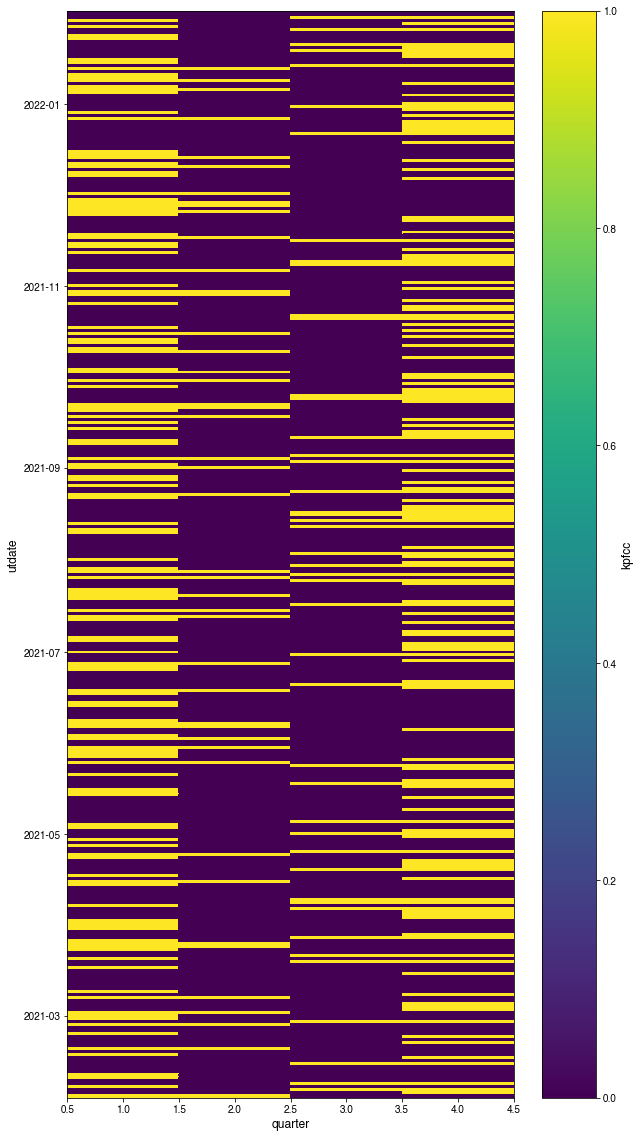

In [288]:
da = df.groupby(['utdate','quarter'])['kpfcc'].first().to_xarray()
da.coords['utdate'] = Time(list(array(da.utdate))).datetime
da.sortby(da.utdate,ascending=False).plot.pcolormesh(figsize=(10,20))

<xarray.DataArray 'kpfcc' (utdate: 365, quarter: 4)>
array([[ True,  True, False, False],
       [False, False, False,  True],
       [False, False,  True,  True],
       ...,
       [False, False,  True,  True],
       [False, False, False, False],
       [False, False, False, False]])
Coordinates:
  * utdate   (utdate) datetime64[ns] 2021-02-02 2021-02-03 ... 2022-02-01
  * quarter  (quarter) int64 1 2 3 4

In [289]:
da.sortby(da.utdate,ascending=False)

<xarray.DataArray 'kpfcc' (utdate: 365, quarter: 4)>
array([[False, False, False, False],
       [False, False, False, False],
       [False, False,  True,  True],
       ...,
       [False, False,  True,  True],
       [False, False, False,  True],
       [ True,  True, False, False]])
Coordinates:
  * utdate   (utdate) datetime64[ns] 2022-02-01 2022-01-31 ... 2021-02-02
  * quarter  (quarter) int64 1 2 3 4

In [276]:
Time(array(da.utdate),format='iso',scale='utc')

ValueError: Input values did not match the format class iso:
TypeError: Input values for iso class must be strings

array([datetime.datetime(2021, 2, 2, 0, 0),
       datetime.datetime(2021, 2, 3, 0, 0),
       datetime.datetime(2021, 2, 4, 0, 0),
       datetime.datetime(2021, 2, 5, 0, 0),
       datetime.datetime(2021, 2, 6, 0, 0),
       datetime.datetime(2021, 2, 7, 0, 0),
       datetime.datetime(2021, 2, 8, 0, 0),
       datetime.datetime(2021, 2, 9, 0, 0),
       datetime.datetime(2021, 2, 10, 0, 0),
       datetime.datetime(2021, 2, 11, 0, 0),
       datetime.datetime(2021, 2, 12, 0, 0),
       datetime.datetime(2021, 2, 13, 0, 0),
       datetime.datetime(2021, 2, 14, 0, 0),
       datetime.datetime(2021, 2, 15, 0, 0),
       datetime.datetime(2021, 2, 16, 0, 0),
       datetime.datetime(2021, 2, 17, 0, 0),
       datetime.datetime(2021, 2, 18, 0, 0),
       datetime.datetime(2021, 2, 19, 0, 0),
       datetime.datetime(2021, 2, 20, 0, 0),
       datetime.datetime(2021, 2, 21, 0, 0),
       datetime.datetime(2021, 2, 22, 0, 0),
       datetime.datetime(2021, 2, 23, 0, 0),
       datetime.da